# LOVE19 ESSD - Horizontal Data Example

Here we image a submeso structure using the DTS, demonstrating the novelty and importance of these data for the atmospheric sciences community.

- This script assumes it is located inside a subdirectory of the ESSD/Zenodo data.
- The Zenodo directory has an assumed architecture. Note that Zenodo does not allow a directory structure, so the data would need to be reorganized or the directory paths provided would need to be altered in order to run this script.
- The script demonstrates the use of the horizontal FODS elements of LOVE19: inner rectangle, NS-transect, FODS air temperature and wind speed on the 12m tower, CSAT fluxes from the 12m tower.

In [18]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import pyfocs

# OS interaction
import os

# import plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime
import seaborn as sns


In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#3498db", "#FFBF00", "#95a5a6", "#34495e", "#e74c3c", "#9b59b6",]
sns.set_palette(sns.color_palette(flatui))

pd.plotting.register_matplotlib_converters()

# Directories

In [3]:
# Assumes a particular relative location between the notebook and ESSD repository.
# Additionally, the Zendodo repository was locally organized into subdirectories.
# To run the notebook you will need to point these directories to where your data
# are located.
dir_notebook = os.getcwd()
os.chdir('../..')
dir_essd = os.getcwd()
dir_essd = os.path.join(dir_essd, 'love_dts/ESSD-repository')

# Met data
dir_csat_flux = os.path.join(dir_essd, 'CSAT fluxes')
dir_csat_ts = os.path.join(dir_essd, 'CSAT 20Hz')
dir_aws = os.path.join(dir_essd, 'AWS')

# Figures
dir_print = os.path.join(dir_essd, 'figures')

# DTS data
dir_fods_cross = os.path.join(dir_essd, 'FODS', 'FODS-cross')
dir_oa = os.path.join(dir_essd, 'FODS', 'outer-array')
dir_heating = os.path.join(dir_essd, 'FODS', 'heating-rates')
dir_flyfox_data = os.path.join(dir_essd, 'FODS', 'FlyFOX')

# Ground-based remote sensing
dir_sodar = os.path.join(dir_essd, 'remote-sensing', 'SODAR-RASS')
dir_lidar = os.path.join(dir_essd, 'remote-sensing', 'LIDAR')

In [5]:
# To get the height above ground level and not the
# height relative to the fixed reference point, 
# we need to account for the local topography using these
# values
z_tb = 1.448183004 + 0.1
z_fc = 0.342392171 + 1.61

# Gather Data

## CSAT Data

In [8]:
os.chdir(dir_csat_flux)
csat_1min = xr.open_dataset('LOVE19_CSAT_1min_fluxes.v2020-12-03.nc')
csat_1min_qc = xr.open_dataset('LOVE19_CSAT_1min_qaqc.v2020-12-03.nc')
csat_10min_qc = xr.open_dataset('LOVE19_CSAT_10min_qaqc.v2020-12-03.nc')

csat_names = ['0.5m', '1m', '4m', '12m']

csat_1min.coords['names'] = (('z'), csat_names)
csat_1min = csat_1min.swap_dims({'z': 'names'})

csat_1min_qc.coords['names'] = (('z'), csat_names)
csat_1min_qc = csat_1min_qc.swap_dims({'z': 'names'})

# Adjust the CSAT data labels
csat_names = ['0.5m', '1m', '4m', '12m']
csat_1min.coords['names'] = (('z'), csat_names)
csat_1min = csat_1min.swap_dims({'z': 'names'})

## AWS

In [9]:
os.chdir(dir_aws)
aws = xr.open_dataset('AWS_Voi_1min.nc')

## DTS Data

In [11]:
# FODS-cross + tower, heated and unheated stainless steel fibers
ds_ns_hot = xr.open_mfdataset(
    os.path.join(
        dir_fods_cross, '*2019-07-22*_heated.nc'
    ),
    combine='by_coords'
)
ds_ns_cold = xr.open_mfdataset(
    os.path.join(
        dir_fods_cross, '*2019-07-22*_unheated.nc'
    ),
    combine='by_coords'
)

# Outer array

ds_p1 = xr.open_mfdataset(
    os.path.join(
        dir_oa, '*2019-07-22*_p1.nc'
    ),
    combine='by_coords'
)

ds_ss_hot = xr.open_mfdataset(
    os.path.join(
        dir_oa, '*2019-07-22*_heated.nc'
    ),
    combine='by_coords'
)

ds_ss_cold = xr.open_mfdataset(
    os.path.join(
        dir_oa, '*2019-07-22*_unheated.nc'
    ),
    combine='by_coords'
)

### Prune to just the pre-morning period and load into memory for ease of computation

In [12]:
ds_ns_hot = ds_ns_hot.sel(time=slice(None, '2019-07-22 06:00')).load()
ds_ns_cold = ds_ns_cold.sel(time=slice(None, '2019-07-22 06:00')).load()

ds_p1 = ds_p1.sel(time=slice(None, '2019-07-22 06:00')).load()
ds_ss_hot = ds_ss_hot.sel(time=slice(None, '2019-07-22 06:00')).load()
ds_ss_cold = ds_ss_cold.sel(time=slice(None, '2019-07-22 06:00')).load()

### Tower temperature and wind speed

In [13]:
ds_tower_cold = ds_ns_cold.where((ds_ns_cold.unheated == 'tower'), drop=True)
ds_tower_hot = ds_ns_hot.where((ds_ns_hot.heated == 'tower'), drop=True)

In [14]:
# Fiber properties

# Fiber radius in meters
rad = 1.32 / 2 * 10**(-3)

# Calculate the density
volume_per_m = rad ** 2 * np.pi * 1
kg_per_m = 5 / 1000
density = kg_per_m / volume_per_m
density_per_m_fiber = density * volume_per_m

# The estimate of the heating rate from the tower wind speed evaluation (see manuscript).
# In W/m
p = 4.5
params = {
    'rad': rad,
    'crv': 502, # Estimate from vR20. The storage term is small and plays a tertiary role.
    'density': density_per_m_fiber
}

# We need the AWS data to estimate the radiative fluxes
aws_sub = aws.reindex_like(ds_tower_cold.time, method='nearest')

tower_wind_speed  = pyfocs.wind_speed.calculate(
    ds_tower_hot.cal_temp + 273.15,
    ds_tower_cold.cal_temp + 273.15,
    p,
    (aws_sub['Rlwd (CNR4)'] + aws_sub['Rlwu (CNR4)']),
    method='vR20',
    params=params,
)

### Outer Array wind speed

In [15]:
os.chdir(dir_heating)
# Open the estimated heating rates and assign to the "hot" dataset
ds_or_heat = xr.open_dataset('outer-rectangle_heating-rates.nc')
ds_ss_hot['power'] = ds_or_heat.outer_rectangle

### Calculate Wind Speed

Here we need to include the fiber parameters as well as the longwave in and out. We use the van Ramshorst 2020 method for calculating wind speed.

In [16]:
# Fiber properties

# Fiber radius in meters
rad = 1.04 / 2 * 10**(-3)

# Calculate the fiber's density
volume_per_m = rad ** 2 * np.pi * 1
kg_per_m = 3 / 1000
density = kg_per_m / volume_per_m
density_per_m_fiber = density * volume_per_m

params = {
    'rad': rad,
    'crv': 502, # Estimate from vR20. The storage term is small and plays a tertiary role.
    'density': density_per_m_fiber
}

# As before, we need the radiative fluxes from the AWS
aws_sub = aws.reindex_like(ds_ss_hot.time, method='nearest')

oa_wind_speed = pyfocs.wind_speed.calculate(
    ds_ss_hot.cal_temp + 273.13,
    ds_ss_cold.cal_temp + 273.13,
    ds_ss_hot.power / 2,
    (aws_sub['Rlwd (CNR4)'] + aws_sub['Rlwu (CNR4)']),
    method='vR20',
    params=params
)

# Break into horizontal wind speed components, based on what
# direction is orthogonal to the fiber.
ns_components = ['OR_SE', 'OR_NW']
logic = [oa_wind_speed.unheated == l for l in ns_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_ns = oa_wind_speed.where(logic, drop=True)

ew_components = ['OR_SW2', 'OR_SW1', 'OR_NE1', 'OR_NE2']
logic = [oa_wind_speed.unheated == l for l in ew_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_ew = oa_wind_speed.where(logic, drop=True)

### The North-South transect

(originally named the mane)

In [19]:
ds_mane = ds_ns_cold.where(
    (
        (ds_ns_cold.unheated == 'mane_south')
        | (ds_ns_cold.unheated == 'mane_north')
    ),
    drop=True
)

# Build the figure

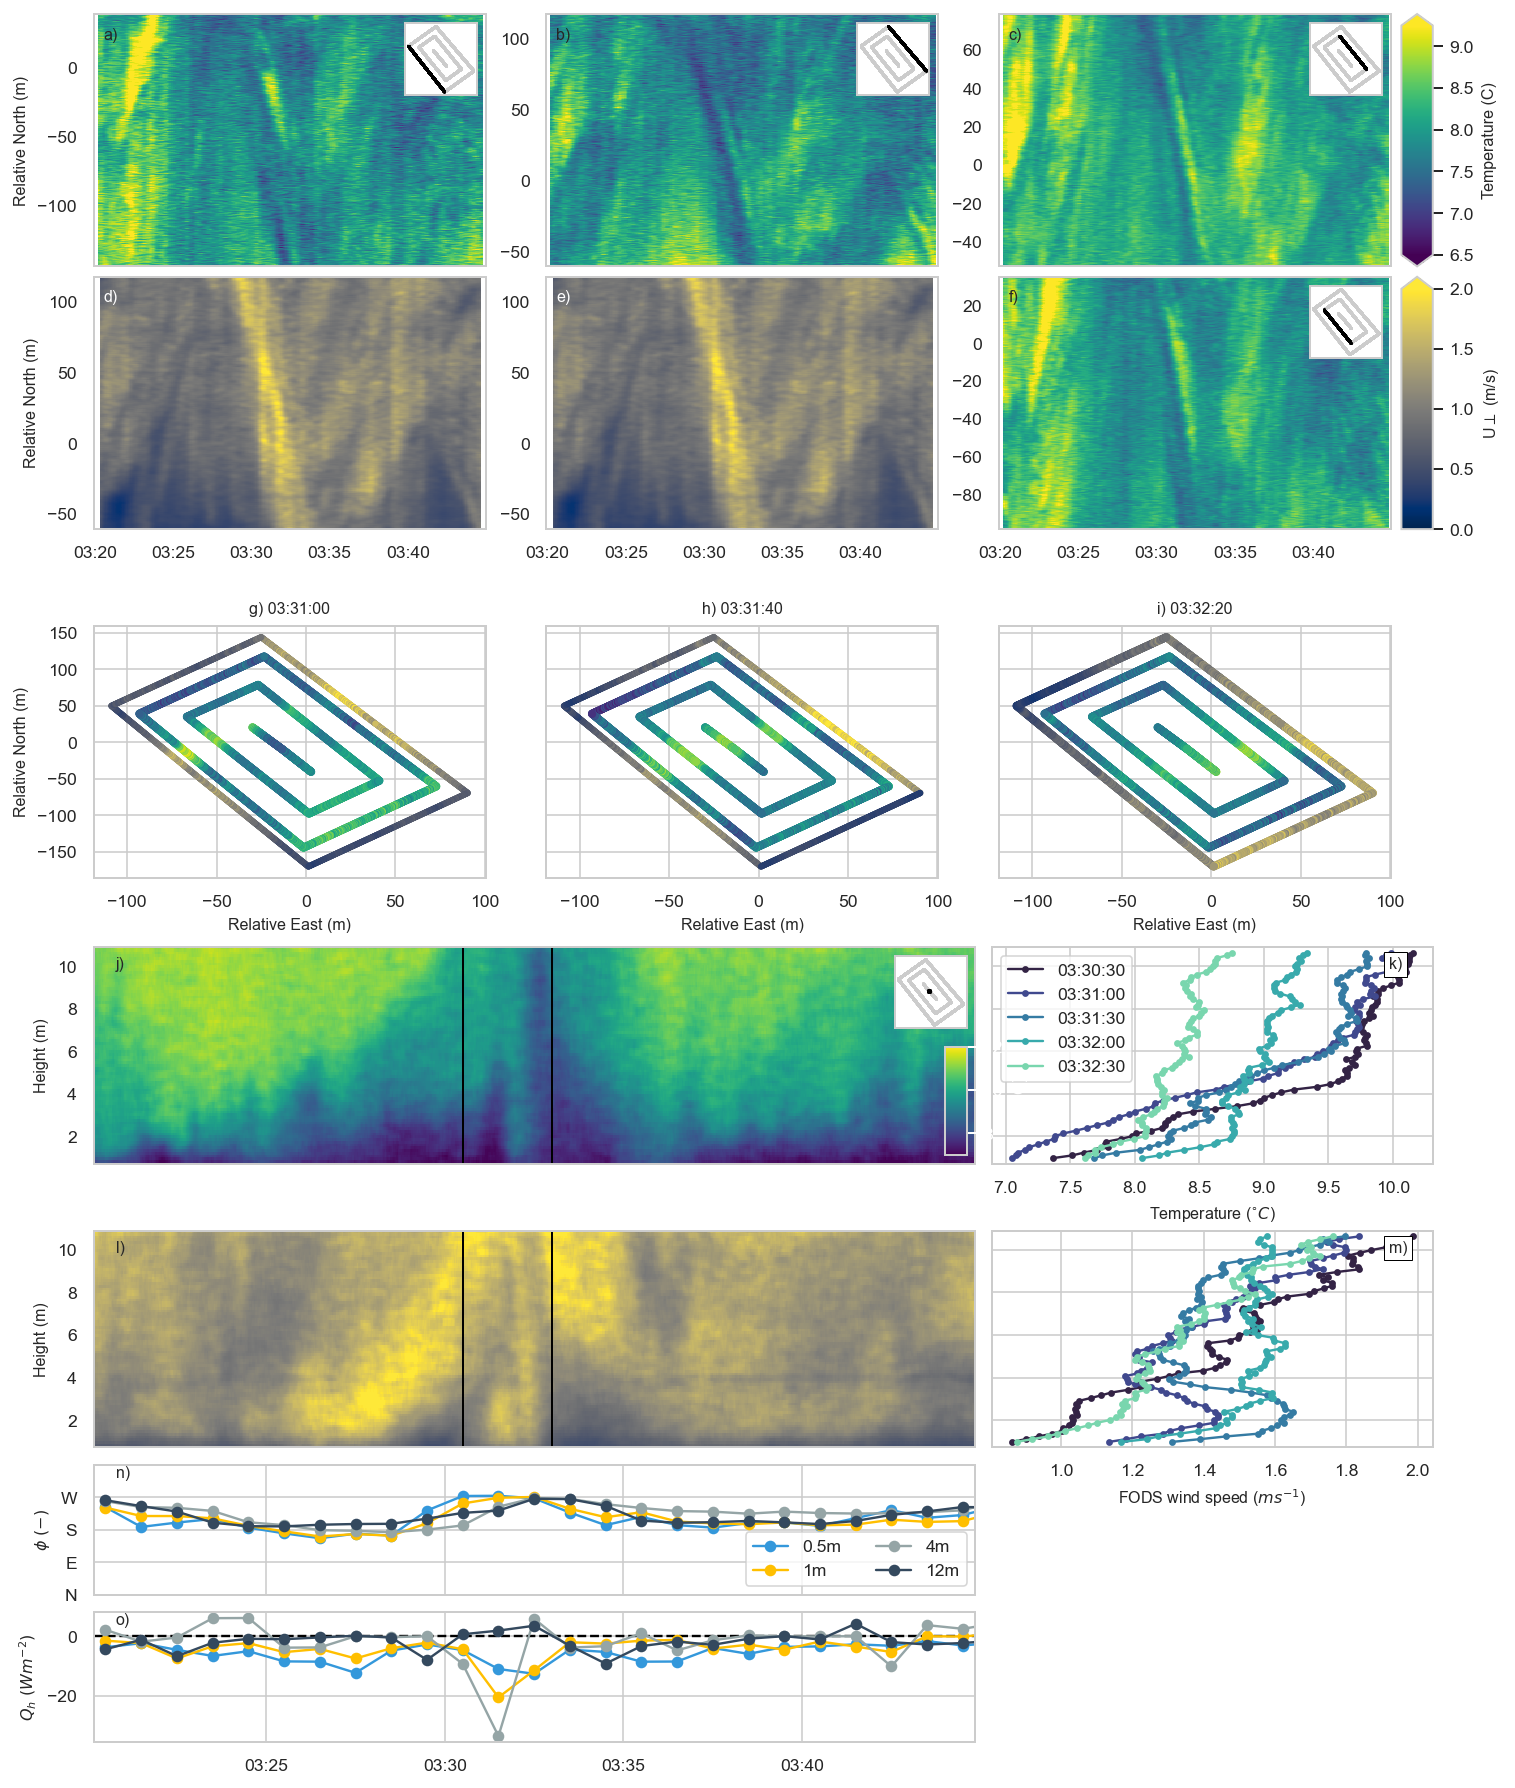

In [23]:
# Building the figure
fig = plt.figure(figsize=(12, 12))

spec = fig.add_gridspec(
    top=1,
    bottom=0.5,
    ncols=6,
    nrows=4,
    width_ratios=[1, 0.1, 1, 0.1, 1, 0.08,],
    height_ratios=[1, 1, 0.3, 1,],
    hspace=0.05, wspace=0.05,
)

ax_or_sw_t = fig.add_subplot(spec[0, 0])
ax_or_sw_u = fig.add_subplot(spec[1, 0])

ax_or_ne_t = fig.add_subplot(spec[0, 2])
ax_or_ne_u = fig.add_subplot(spec[1, 2])

ax_ir_ne = fig.add_subplot(spec[0, 4])
ax_ir_sw = fig.add_subplot(spec[1, 4])

ax_dts_before = fig.add_subplot(spec[3, 0])
ax_dts_during = fig.add_subplot(spec[3, 2])
ax_dts_after = fig.add_subplot(spec[3, 4])

ax_ew_cbar = fig.add_subplot(spec[1, -1])
ax_t_cbar = fig.add_subplot(spec[0, -1])

spec = fig.add_gridspec(
    top=0.46,
    bottom=0,
    ncols=2,
    nrows=5,
    width_ratios=[2, 1],
    height_ratios=[1, 0.15, 1, 0.6, 0.6],
    hspace=0.12, wspace=0.025,
)

ax_tower_t = fig.add_subplot(spec[0, 0])
ax_tower_u = fig.add_subplot(spec[2, 0])
ax_tower_u.get_shared_x_axes().join(ax_tower_u, ax_tower_t)

ax_tower_t_profiles = fig.add_subplot(spec[0, 1])
ax_tower_u_profiles = fig.add_subplot(spec[2, 1])
ax_tower_t_profiles.get_shared_y_axes().join(ax_tower_t_profiles, ax_tower_t, )
ax_tower_u_profiles.get_shared_y_axes().join(ax_tower_u_profiles, ax_tower_u, )

ax_csat_phi = fig.add_subplot(spec[3, 0])
ax_csat_h = fig.add_subplot(spec[4, 0])
ax_csat_phi.get_shared_x_axes().join(ax_csat_phi, ax_tower_t)
ax_csat_h.get_shared_x_axes().join(ax_csat_h, ax_tower_t)

# Plotting and data parameters
t1 = '2019-07-22 03:20:00'
t2 = '2019-07-22 03:45:00'
tslice = slice(t1, t2)

t1_before = '2019-07-22 03:31:00'
t2_before = '2019-07-22 03:31:20'
tslice_before = slice(t1_before, t2_before)

t1_during = '2019-07-22 03:31:40'
t2_during = '2019-07-22 03:32:00'
tslice_during = slice(t1_during, t2_during)

t1_after = '2019-07-22 03:32:20'
t2_after = '2019-07-22 03:32:40'
tslice_after = slice(t1_after, t2_after)

vmin = 6.5
vmax = 9.25

vmin_u = 0.
vmax_u = 2.

vmin_tower = 7
vmax_tower = 12


# ----------------------------------------------------------------------------------------------
# Outer Array - SW
ds_temp = ds_ss_cold.where(
    (ds_ss_cold.unheated=='OR_SW2') | (ds_ss_cold.unheated=='OR_SW1'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_temp = ds_temp.sortby(ds_temp.y)

ds_wind = wind_speed_ew.where(
    (wind_speed_ew.unheated=='OR_NE1') | (wind_speed_ew.unheated=='OR_NE2'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_wind = ds_wind.swap_dims({'xyz': 'y'})
ds_wind = ds_wind.sortby(ds_wind.y)
ds_wind = ds_wind.rolling(time=5, center=True).mean()
ds_wind = ds_wind.rolling(y=10, center=True).mean()

ax = ax_or_sw_t
im = ax.pcolormesh(
    ds_temp.time, ds_temp.y, ds_temp.cal_temp.T.values,
    cmap='viridis', vmin=vmin, vmax=vmax, rasterized=True, shading='nearest')
ax.set_ylabel('Relative North (m)')
ax.text(0.025, 0.9, 'a)', horizontalalignment='left', transform=ax.transAxes)
ax.set_xticklabels([])

# Inset map
axins = inset_axes(
    ax,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

ax = ax_or_sw_u
im = ax.pcolormesh(
    ds_wind.time, ds_wind.y, ds_wind.values,
    cmap='cividis', vmin=vmin_u, vmax=vmax_u, rasterized=True, shading='auto')
ax.text(0.025, 0.9, 'd)', horizontalalignment='left', transform=ax.transAxes, color='w')
ax.set_ylabel('Relative North (m)')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

# ------------------------------------------------------------------------------------------
# Outer Array - SW
ds_temp = ds_ss_cold.where(
    (ds_ss_cold.unheated=='OR_NE2') | (ds_ss_cold.unheated=='OR_NE1'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_temp = ds_temp.sortby(ds_temp.y)

ds_wind = wind_speed_ew.where(
    (wind_speed_ew.unheated=='OR_NE1') | (wind_speed_ew.unheated=='OR_NE2'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_wind = ds_wind.swap_dims({'xyz': 'y'})
ds_wind = ds_wind.sortby(ds_wind.y)
ds_wind = ds_wind.rolling(time=5, center=True).mean()
ds_wind = ds_wind.rolling(y=10, center=True).mean()

ax = ax_or_ne_t
im = ax.pcolormesh(
    ds_temp.time, ds_temp.y, ds_temp.cal_temp.T.values,
    cmap='viridis', vmin=vmin, vmax=vmax, rasterized=True, shading='auto')
ax.text(0.025, 0.9, 'b)', horizontalalignment='left', transform=ax.transAxes)
ax.set_xticklabels([])

# Inset map
axins = inset_axes(
    ax,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

ax = ax_or_ne_u
im = ax.pcolormesh(
    ds_wind.time, ds_wind.y, ds_wind.values,
    cmap='cividis', vmin=vmin_u, vmax=vmax_u, rasterized=True, shading='auto')
ax.text(0.025, 0.9, 'e)', horizontalalignment='left', transform=ax.transAxes, color='w')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

# -------------------------------------------------------------------------------------------
# Inner Array - NE
ds_temp = ds_p1.where(
    (ds_p1.p1=='IR_NE2') | (ds_p1.p1=='IR_NE1'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_temp = ds_temp.sortby(ds_temp.y)

ax = ax_ir_ne
im = ax.pcolormesh(ds_temp.time, ds_temp.y, ds_temp.cal_temp.T.values,
                cmap='viridis', vmin=vmin, vmax=vmax, rasterized=True, shading='auto')
ax.text(0.025, 0.9, 'c)', horizontalalignment='left', transform=ax.transAxes)
ax.set_xticklabels([])

# Inset map
axins = inset_axes(
    ax,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

# ------------------------------------------------------------------------------------------
# Inner Array - SW
ds_temp = ds_p1.where(
    (ds_p1.p1=='IR_SW2') | (ds_p1.p1=='IR_SW1'),
    drop=True).sel(time=tslice).rolling(time=5, center=True).mean()
ds_temp = ds_temp.sortby(ds_temp.y)

ax = ax_ir_sw
im = ax.pcolormesh(
    ds_temp.time, ds_temp.y, ds_temp.cal_temp.T.values,
    cmap='viridis', vmin=vmin, vmax=vmax, rasterized=True, shading='auto')
ax.text(0.025, 0.9, 'f)', horizontalalignment='left', transform=ax.transAxes)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

# Inset map
axins = inset_axes(
    ax,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_temp.x.values,
    ds_temp.y.values,
    0.5,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

# ---------------------------------------------------------------------------------------------
# DTS snapshots
# Before
ax = ax_dts_before
ds_plot = ds_p1.sel(time=tslice_before).mean(dim='time')

ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_ss_cold.sel(time=tslice_before).mean(dim='time')
ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = ds_mane.sel(time=tslice_before).mean(dim='time')
im_t = ax.scatter(ds_plot.x, ds_plot.y, 10, ds_plot.cal_temp, cmap='viridis', vmin=vmin, vmax=vmax)

ds_plot = wind_speed_ew.sel(time=tslice_before).mean(dim='time')
# Since the temperature and wind speed share x-y coordinates, we slightly scale the 
# wind speed coordinates to make them visible around the outside of the array.
im_ew = ax.scatter(
    ds_plot.x * 1.2 + 3,
    ds_plot.y * 1.2 + 3,
    5,
    ds_plot,
    cmap='cividis',
    vmin=vmin_u,
    vmax=vmax_u
)

ds_plot = wind_speed_ns.sel(time=tslice_before).mean(dim='time')
im_ns = ax.scatter(
    ds_plot.x * 1.2 + 3,
    ds_plot.y * 1.2 + 3,
    5,
    ds_plot,
    cmap='cividis',
    vmin=vmin_u,
    vmax=vmax_u
)

plt.colorbar(im_t, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel('Temperature (C)')
plt.colorbar(im_ew, cax=ax_ew_cbar, extend='max')
ax_ew_cbar.set_ylabel('U$\perp$ (m/s)')

ax.set_xlabel('Relative East (m)')
ax.set_ylabel('Relative North (m)')
ax.set_title('g) ' + pd.Timestamp(t1_before).strftime('%H:%M:%S'))

# During
ax = ax_dts_during

ds_plot = ds_p1.sel(time=tslice_during).mean(dim='time')
ax.scatter(
    ds_plot.x,
    ds_plot.y,
    10,
    ds_plot.cal_temp,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)

ds_plot = ds_ss_cold.sel(time=tslice_during).mean(dim='time')
ax.scatter(
    ds_plot.x,
    ds_plot.y,
    10,
    ds_plot.cal_temp,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)

ds_plot = ds_mane.sel(time=tslice_during).mean(dim='time')
ax.scatter(
    ds_plot.x,
    ds_plot.y,
    10,
    ds_plot.cal_temp,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)

ds_plot = wind_speed_ew.sel(time=tslice_during).mean(dim='time')
ax.scatter(
    ds_plot.x * 1.2 + 3,
    ds_plot.y * 1.2 + 3,
    5,
    ds_plot,
    cmap='cividis',
    vmin=vmin_u,
    vmax=vmax_u
)

ds_plot = wind_speed_ns.sel(time=tslice_during).mean(dim='time')
ax.scatter(
    ds_plot.x * 1.2 + 3,
    ds_plot.y * 1.2 + 3,
    5,
    ds_plot,
    cmap='cividis',
    vmin=vmin_u,
    vmax=vmax_u
)

ax.set_xlabel('Relative East (m)')
ax.set_yticklabels([])
ax.set_title('h) ' + pd.Timestamp(t1_during).strftime('%H:%M:%S'))

# After
ax = ax_dts_after

ds_plot = ds_p1.sel(time=tslice_after).mean(dim='time')
ax.scatter(
    ds_plot.x,
    ds_plot.y,
    10,
    ds_plot.cal_temp,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)

ds_plot = ds_ss_cold.sel(time=tslice_after).mean(dim='time')
ax.scatter(
    ds_plot.x,
    ds_plot.y,
    10,
    ds_plot.cal_temp,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)

ds_plot = ds_mane.sel(time=tslice_after).mean(dim='time')
ax.scatter(
    ds_plot.x,
    ds_plot.y,
    10,
    ds_plot.cal_temp,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)

ds_plot = wind_speed_ew.sel(time=tslice_after).mean(dim='time')
ax.scatter(
    ds_plot.x * 1.2 + 3,
    ds_plot.y * 1.2 + 3,
    10,
    ds_plot,
    cmap='cividis',
    vmin=vmin_u,
    vmax=vmax_u
)

ds_plot = wind_speed_ns.sel(time=tslice_after).mean(dim='time')
ax.scatter(
    ds_plot.x * 1.2 + 3,
    ds_plot.y * 1.2 + 3,
    10,
    ds_plot,
    cmap='cividis',
    vmin=vmin_u,
    vmax=vmax_u
)

ax.set_yticklabels([])
ax.set_xlabel('Relative East (m)')
ax.set_title('i) ' + pd.Timestamp(t1_after).strftime('%H:%M:%S'))

# -----------------------------------------------------------------------------------------
# Tower Time-Height cross-sections

# Time slices for the submeso motion
tbeg = '2019-07-22 03:30:30'
tend = '2019-07-22 03:32'

ds_plot = ds_tower_cold.sel(time=tslice)
dt = pd.Timedelta(ds_plot.dt).seconds
ds_plot = ds_plot.rolling(time=20 // dt, center=True).mean()
ds_plot = ds_plot.swap_dims({'xyz': 'z'}).rolling(z=3, center=True, min_periods=2).mean()

# The "z_tb" term accounts for the difference between height above the surface
# and the measured height relative to a fixed location using a theodolit.
ax = ax_tower_t
im = ax.pcolormesh(
    ds_plot.time,
    ds_plot.z + z_tb,
    ds_plot.cal_temp.T,
    cmap='viridis',
    vmin=vmin_tower,
    vmax=vmax_tower,
    rasterized=True,
    shading='auto'
)

axins = inset_axes(
    ax, 
    width="2.5%",
    height="50%",
    loc='lower right'
)
axins.yaxis.set_ticks_position('left')
axins.yaxis.set_label_position('left')

# The tower needs a seperate color scale due to the temp. gradient
cb = plt.colorbar(
    im,
    cax=axins,
    orientation="vertical",
)
cb.set_label('T ($^{\circ}$ C)', color='w')
cb.ax.yaxis.set_tick_params(color='w')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='w')

ax.axvline([tbeg], color='k', linewidth=1)
ax.axvline([pd.Timestamp(tend) + pd.Timedelta(minutes=1)], color='k', linewidth=1)
ax.set_ylabel('Height (m)')
ax.text(
    0.025, 0.9, 'j)', horizontalalignment='left', 
    transform=ax.transAxes,
)
ax.set_xticklabels([])

# Inset map
axins = inset_axes(
    ax,
    width=0.5,  # width = 25% of parent_bbox width
    height=0.5,  # height : 5%
    loc='upper right')
axins.scatter(
    ds_ss_cold.x.values,
    ds_ss_cold.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_p1.x.values,
    ds_p1.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_mane.x.values,
    ds_mane.y.values,
    0.5,
    color='0.8'
)
axins.scatter(
    ds_plot.x.values,
    ds_plot.y.values,
    2,
    color='k'
)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])

# Tower wind speed
ds_plot = tower_wind_speed.sel(time=tslice)
ds_plot = ds_plot.rolling(time=20 // dt, center=True).mean()
ds_plot = ds_plot.swap_dims({'xyz': 'z'}).rolling(z=3, center=True, min_periods=2).mean()

ax = ax_tower_u
im = ax.pcolormesh(
    ds_plot.time,
    ds_plot.z + z_tb,
    ds_plot.T,
    cmap='cividis',
    vmin=vmin_u,
    vmax=vmax_u,
    rasterized=True,
    shading='auto'
)
ax.axvline([tbeg], color='k', linewidth=1)
ax.axvline([pd.Timestamp(tend) + pd.Timedelta(minutes=1)], color='k', linewidth=1)
ax.set_ylabel('Height (m)')
ax.text(0.025, 0.9, 'l)', horizontalalignment='left', transform=ax.transAxes)
ax.set_xticklabels([])

ds_plot = ds_plot.dropna(dim='time').dropna(dim='z')
ymin = ds_plot.z.min() + z_tb
ymax = ds_plot.z.max() + z_tb
tmin = ds_plot.time.min().values
tmax = ds_plot.time.max().values

# --------------------------------------------------------------------------------------------
# Tower time means
t_sm = '2019-07-22 03:31'
tresample = '30s'

ax = ax_tower_t_profiles
ds_plot = ds_tower_cold.swap_dims({'xyz': 'z'}).rolling(z=5, center=True).mean()
ds_plot = ds_plot.resample(time=tresample).mean()
ds_plot = ds_plot.sel(time=slice(tbeg, tend))
tcolor = sns.color_palette('mako', len(ds_plot.time))

for n, t in enumerate(ds_plot.time):
    if pd.Timestamp(t.values) == pd.Timestamp(t_sm):
        n_sm = n
    tl = pd.Timestamp(t.values).strftime('%H:%M:%S')
    ax.plot(
        ds_plot.sel(time=t).cal_temp,
        ds_plot.z + z_tb,
        marker='.',
        color=tcolor[n],
        label=tl
    )

ax.legend()
ax.set_xlabel('Temperature ($^{\circ} C$)')
ax.set_yticklabels([])
ax.text(
    0.9, 0.9, 'k)', horizontalalignment='left',
    transform=ax.transAxes,
    bbox=dict(boxstyle="square", fc="white", ec="k", lw=0.5)
)
ax.set_ylim(ymin, ymax)

ax = ax_tower_u_profiles
ds_plot = tower_wind_speed.swap_dims({'xyz': 'z'}).rolling(z=5, center=True).mean()
ds_plot = ds_plot.resample(time=tresample).mean()
ds_plot = ds_plot.sel(time=slice(tbeg, tend))

for n, t in enumerate(ds_plot.time):
    ax.plot(
        ds_plot.sel(time=t), ds_plot.z + z_tb, marker='.', color=tcolor[n])
ax.set_xlabel('FODS wind speed ($m s^{-1} $)')
ax.set_yticklabels([])
ax.text(
    0.9, 0.9, 'm)', horizontalalignment='left',
    transform=ax.transAxes,
    bbox=dict(boxstyle="square", fc="white", ec="k", lw=0.5)
)
ax.set_ylim(ymin, ymax)

# --------------------------------------------------------------------------------------------
# CSAT time series
ds_csat = csat_1min.sel(time=tslice)

ax = ax_csat_phi
for n in ds_csat.names:
    # The perturbation time scale puts the time stamp at the beginning of the
    # perturbation interval. Here we visually move it to the middle for ease of
    # interpretation.
    ax.plot(
        ds_csat.time + pd.Timedelta(seconds=30),
        ds_csat['phi'].sel(names=n.names),
        '-o',
        label=n.values
    )
ax.legend(ncol=2, loc='lower right')
ax.set_ylabel('$\phi~ (-)$')
ax.set_ylim(0, 360)
ax.set_yticks([0, 90, 180, 270])
ax.set_yticklabels(['N', 'E', 'S', 'W'])
ax.set_xticklabels([])
ax.text(0.025, 0.9, 'n)', horizontalalignment='left', transform=ax.transAxes)

ax = ax_csat_h
for n in ds_csat.names:
    ax.plot(
        ds_csat.time + pd.Timedelta(seconds=30),
        ds_csat['H'].sel(names=n.names),
        '-o',
        label=n.values
    )
ax.set_ylabel('$Q_h~ (Wm^{-2})$')
ax.axhline(0, ls='--', color='k', zorder=1)
ax.text(0.025, 0.9, 'o)', horizontalalignment='left', transform=ax.transAxes)
ax.set_xlim(tmin, tmax)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

os.chdir(dir_print)
fig.savefig('ESSD-LOVE19_horizontal-example.v2.pdf', bbox_inches='tight')
fig.savefig('ESSD-LOVE19_horizontal-example.v2.png', bbox_inches='tight', dpi=300)